# Aproksymacja splinami minimalizowana ze względu na wariancję.

In [1]:
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal
from scipy.interpolate import make_lsq_spline, BSpline
from scipy.interpolate import make_interp_spline
from scipy.interpolate import splrep

import test_data as td
if td.DATA is None:
    td.set_test_data(
    data_size=5000, 
    start_time=datetime.datetime(2023, 3, 21, 12, 24).timestamp(),
    moving_av=False
    )


Test data size is 5000
Test data start time is 2023:03:21 11:25
Test data end time is   2023:03:24 22:44
Subtracting moving avarage: False


In [2]:
import core as co
import least_sq_fit_piecewise as ls

Test data size is 10002
Test data start time is 2023:01:02 22:58
Test data end time is   2023:01:09 21:39
Subtracting moving avarage: True


In [3]:
spline_order = 2
approx_acc = 5e-5

shift = 0
length = 1200
limits = (0 + shift, length + shift)
shift = 0
value = td.VALUE[limits[0]: limits[1]]
cndl_count = np.arange(*limits, dtype='float64')

savgol_filter = co.Savgol_filter(window=50, order=3)
filtered_savgol = savgol_filter.filter(value)

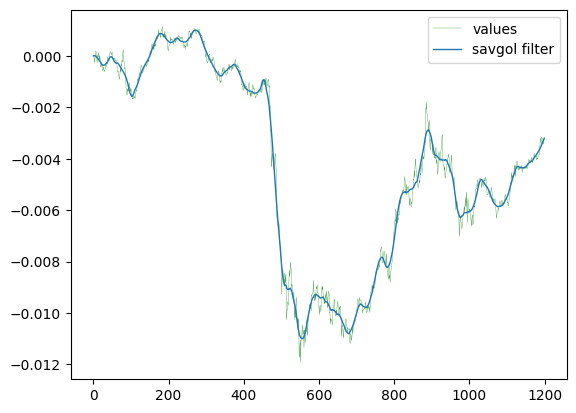

In [4]:
plt.plot(cndl_count, value, label='values', color='green', linewidth=0.2)
plt.plot(cndl_count, filtered_savgol, label='savgol filter', linewidth=1)

plt.legend()
plt.show()

[1.122e-03 1.697e-03 2.640e-03 4.664e-03 5.430e-03 5.021e-03 6.901e-03
 7.313e-03 8.950e-03 9.847e-03 1.871e-04 -1.225e-03 7.283e-04 5.965e-04
 -1.701e-03 -9.987e-03 -8.506e-03 -1.016e-02 -9.581e-03 -3.007e-03
 -6.161e-03 -3.752e-03]


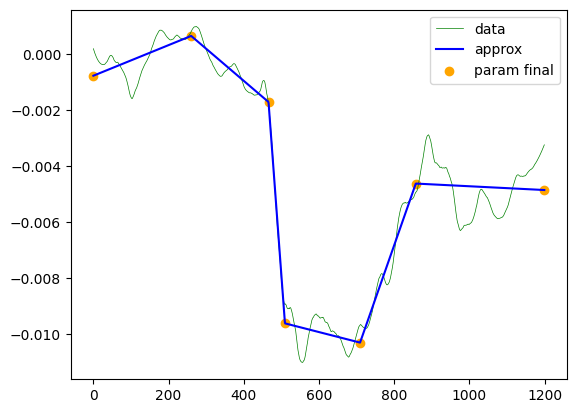

In [9]:

def power_spectrum(values, freq=0, filter=False):
    if values is None:
        return None, None, None
    ps = np.abs(np.fft.fft(values))**2
    freqs = np.fft.fftfreq(len(values), d=1)
    idx = np.argsort(freqs)
    freqencies = freqs[idx]
    log_powers = [math.log10(p) for p in ps[idx]] 
    log_powers_filtered = signal.savgol_filter(log_powers, 100, 2)
    for i in range(len(freqencies)):
        if freqencies[i] > - math.fabs(freq):
            log_power = log_powers_filtered[i]
            break

    if filter:
        log_powers = log_powers_filtered
    return freqencies, log_powers, 10 ** log_power

filter = co.Savgol_filter(window=50, order=2)
filtered = filter.filter(value)

piecewise = ls.LeastSq(ls.Splines(cndl_count, filtered, scale_x=1.e-5, number_pieces=5, k=1) )
piecewise.run()
print(p)
clazz = piecewise.func_class

plt.plot(cndl_count, filtered, color='green', label='data', linewidth='0.5')
plt.plot(cndl_count, clazz.approx(cndl_count), color='blue', label='approx')
plt.scatter(*clazz.knots(), color='orange', label='param final')

# freqencies, log_powers, power = power_spectrum(value, freq=0.3, filter=True)
# if freqencies is not None:
#     print(f'{power:1.1e}')
#     plt.plot(freqencies, log_powers, label='values')

# freqencies, log_powers, power = power_spectrum(filtered, freq=0.3, filter=False)
# if freqencies is not None:
#     print(f'{power:1.1e}')
#     plt.plot(freqencies, log_powers, label='filtered')

plt.legend()
plt.show()

3.900832978699483e-07
1.2316460485821105e-07
6.168270445947893e-08


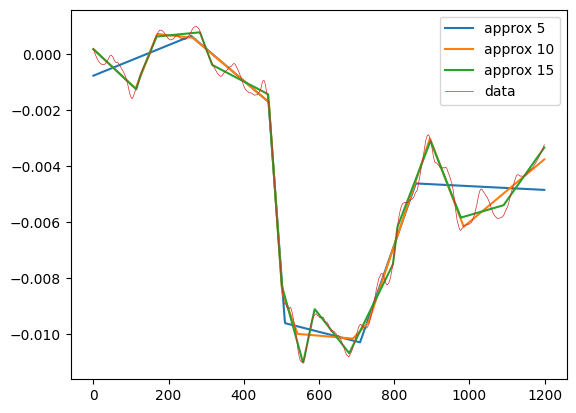

In [11]:
for n in [5, 10, 15]:
    piecewise = ls.LeastSq(ls.Splines(cndl_count, filtered, scale_x=1.e-5, number_pieces=n, k=1) )
    piecewise.run()
    clazz = piecewise.func_class
    variance = sum(clazz.func() ** 2)
    print(variance)
    plt.plot(cndl_count, clazz.approx(cndl_count), label=f'approx {n}')

plt.plot(cndl_count, filtered, label='data', linewidth='0.5')
plt.legend()
plt.show()

## Czy tokenizacja jest stabilna.

Ustalamy doświadczalnie okres czasu przeszłego stanowiący context decyzji: tokeny z tego okresu zasilają procesor AI. Nie chcemy żeby ten ciąg tokenów zmieniał się nie tylko przez przesunięcie końców - ewoluował wewnętrz tego okresu obserwacji.

Widzieliśmy już przypadek takiej niestabilności: gdy rysowaliśmy zęby piły na wykresie. Ta niestabilność wynika z lokalności metody określania końców tokenów. Tak samo ograniczanie w miejscach relatywnej 'stabilizacji' prowadzi do niestabilności bo dwa podobne miejsca na wykresie mogą być inaczej tokenizowane przy infinizymalnej różnicy 'stabilizacji'.


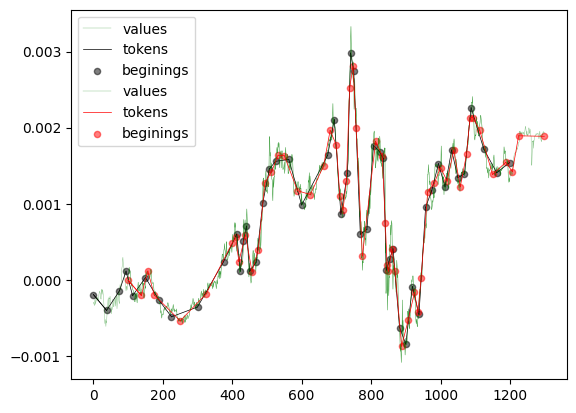

In [141]:
def is_parsing_stable():
    k = 1
    s = 1e-5
    limits = (0,1200)
    intervals, time, value, filtered = splines(
        limits=limits, shift=0,
        k=k, s=s
        )
    plot_splines(intervals, time, value, show=False)

    intervals, time, value, filtered = splines(
        limits=limits, shift=100,
        k=k, s=s
        )    
    plot_splines(intervals, time, value, color='red', show=False)

    # intervals, time, value, filtered = splines(
    #     limits=limits, shift=200,
    #     k=k, s=s
    #     )    
    # plot_splines(intervals, time, value, color='blue', show=False)    

    plt.legend()
    plt.show()

is_parsing_stable() 



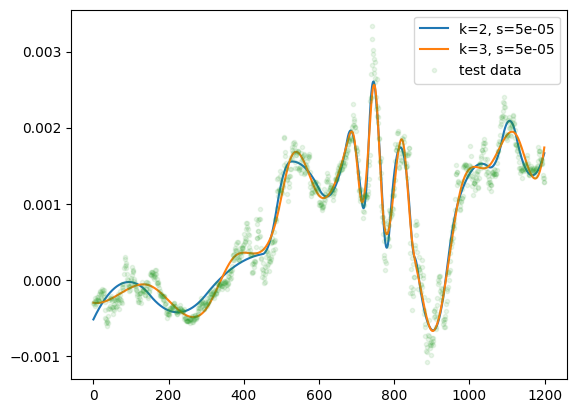

In [105]:
def spline_choice(k=spline_order, s=approx_acc):
    tck = splrep(x_data, y_data, s=s, k=k)
    plt.plot(x_data, BSpline(*tck)(x_data), '-', label=f'k={k}, s={s}')

spline_choice()
spline_choice(k=3)
plt.plot(x_data, y_data, '.', alpha=0.1, label='test data')
plt.legend()
plt.show()

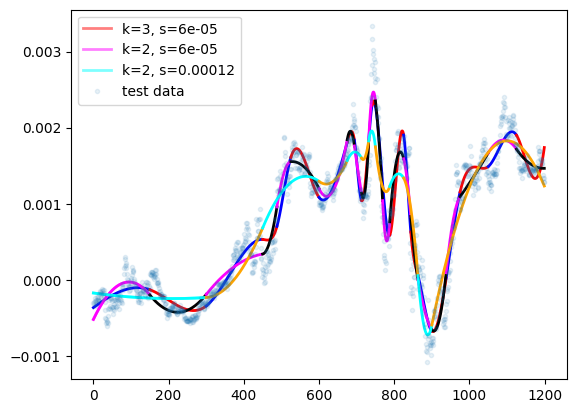

In [151]:
s = 0.00006
k = 2
linewidth = 2

def tokens(k=k, s=s, colors=('red', 'blue')):
    tck = splrep(x_data, y_data, s=s, k=k)
    poly = scipy.interpolate.PPoly.from_spline(tck)
    coefs = poly.c.T 
    knots = poly.x
    intervals = [((knots[i], knots[i+1]), coefs[i]) for i in range(2, len(knots) - 2 * 2 + 1)]
    color = True
    first = 1
    for interval in intervals:
        color = not color
        polynomial = np.poly1d(interval[1])
        x = [_ for _ in range(int(interval[0][0]), int(interval[0][1]) + 1)]
        y = [polynomial(_ - interval[0][0]) for _ in x]
        if first:
            first -= 1
            plt.plot(x, y, label=f'k={k}, s={s}', color=colors[int(color)], linewidth=linewidth, alpha=0.5)
        
        plt.plot(x, y, color=colors[int(color)], linewidth=linewidth, alpha=1)

tokens(k=3)
tokens(k=2, colors=('magenta', 'black'))
tokens(k=2, s=2*s, colors=('cyan', 'orange'))
plt.plot(x_data, y_data, '.', alpha=0.1, label='test data')
plt.legend()
plt.show()


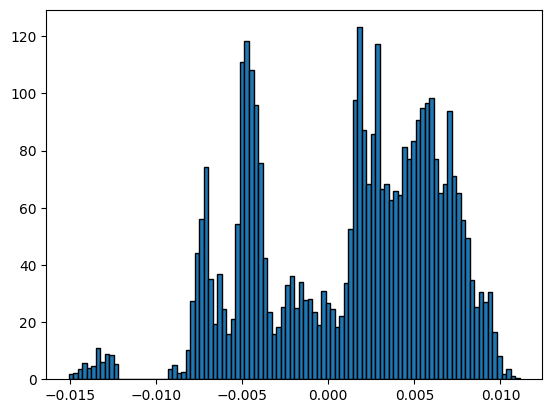

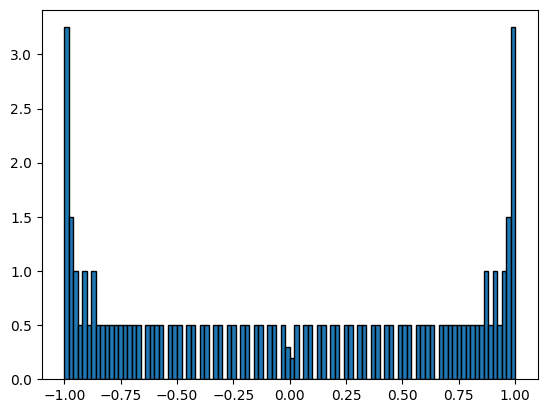

In [135]:
hist_data = [values[1][0] for values in all_data]
plt.hist(hist_data, bins=100, edgecolor='black', density=True)
plt.show()

sin_data = [math.sin(math.pi * n * 0.01) for n in range(5000)]
plt.hist(sin_data, bins=100, edgecolor='black', density=True)
plt.show()